## Classifying photos from Germany, Taipei, and Argentina

The goal of this assignment is to develop a machine learning model that classifies photos taken in three different countries—Germany, Argentina, and Taiwan. By leveraging image processing techniques, dimensionality reduction, and neural networks, we aim to predict the country in which a given image was captured. This process involves data preprocessing and resizing, augmentation, principal component analysis (PCA), and classification.

The images are all taken in outdoor environment with a street view or very little of them with a landscape view (without streets) to ensure that there are enough information to recognize the differences. They include pictures of the streets in the cities or road trip pictures.

### Libraries

First, I loaded all the libraries needed for this assignment. The comments include the functionality of each library

In [ ]:
# preprocessing image
from glob import glob # used to retrieve file paths

from PIL import Image # provides image processing functionalities
from pillow_heif import register_heif_opener # adds support for HEIF/HEIC images
import cv2 # OpenCV: used for image augmentation
from scipy.ndimage import shift # image transformations, such as shifting an image in pixel space

# handling arrays and numerical computations
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# for PCA and machine learning 
from sklearn import decomposition
from sklearn.utils import shuffle # shuffles datasets
from sklearn.model_selection import train_test_split # splits data into training and validation sets
from sklearn.metrics import classification_report, confusion_matrix # evaluates model performance

# building neural network 
from tensorflow.keras.models import Sequential # defines a feedforward neural network model 
from tensorflow.keras.layers import Dense, InputLayer # creates hidden layers
from tensorflow.keras.optimizers import Adam # performs stochastic gradient descent

### Data Preprocessing
To ensure consistency across the dataset, we first preprocess the images:

Image Loading: Images are loaded using the PIL and OpenCV libraries, with support for various file formats, including HEIF/HEIC.

Resizing and converting: All images are resized to 250x250 pixels and 3 color channels for uniformity. They also are converted to RGB color format, meaning that each of them has three color channels: Red, Green, Blue. The original images consist of .jpeg and .heif formats. Images in .jpeg can be stored in RGB or YCbCr, while images in .heif use YCbCr. Both of them can be convert to RGB, making all of them having size of 250x250x3. 

Flattening: Each image is converted into a 1D array for further processing.

Labeling: Each image is assigned a label corresponding to its country (Germany: 0, Argentina: 1, Taiwan: 2).

In [33]:
# Register HEIF support for PIL
register_heif_opener()

def open_image_with_format(path):
    try:
        image = Image.open(path)
        return image.convert('RGB')
    except Exception as e:
        print(f"Error opening {path}: {e}")
        return None

def resize_images(image_paths, target_size=(250, 250)):
    resized_images = []
    for path in image_paths:
        try:
    
            # Open and resize
            image = open_image_with_format(path)
            resized_image = resizeimage.resize_cover(image, target_size)

            # Convert to array
            array = np.array(resized_image)
            
            # Sanity check - ensure all images are 3 channels (RGB)
            if array.shape != (target_size[0], target_size[1], 3):
                print(f"Skipping {path} due to unexpected shape:{array.shape}")
                continue
            
            # Flatten and append
            resized_images.append(array.flatten())
        
        except Exception as e:
            print(f"Error processing {path}: {e}")
        

    return np.stack(resized_images)

In [23]:
# Specifying index for each category of photos for plotting purpose
germany_index = 0
argentina_index = 1
taiwan_index = 2
all_index = 3
reshaped_index = 4

def plot_images(images, index):

    fig = plt.figure(figsize=(15, 6)) 
    countries = ['Germany', 'Argentina', 'Taiwan', 'All', 'Reshaped']
    
    # plot 10 samples of original images
    for i in range(10): 
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[]) 
        # unflatten images
        img = Image.fromarray(images[i].reshape(250,250,3), 'RGB') 
        ax.imshow(img, interpolation='nearest') 
        
    plt.suptitle(f'Images of {countries[index]}', y=0.95)

    plt.show()

#### Load Images from Germany and Plot Samples
My Germany pictures all come from Berlin, so I'm loading them from a folder called Berlin. I'm curious if having photos coming from the same city instead of all over the country can increase model performace as I assume these pictures have more similarities. For Argentina and Taiwan, I include pictures out in the nature (deserts, mountain...) and in cities (mainly Buenos Aires and Taipei), while for Germany, pictures only include city views of Berlin. 

Found 95 images
Total Images: 95


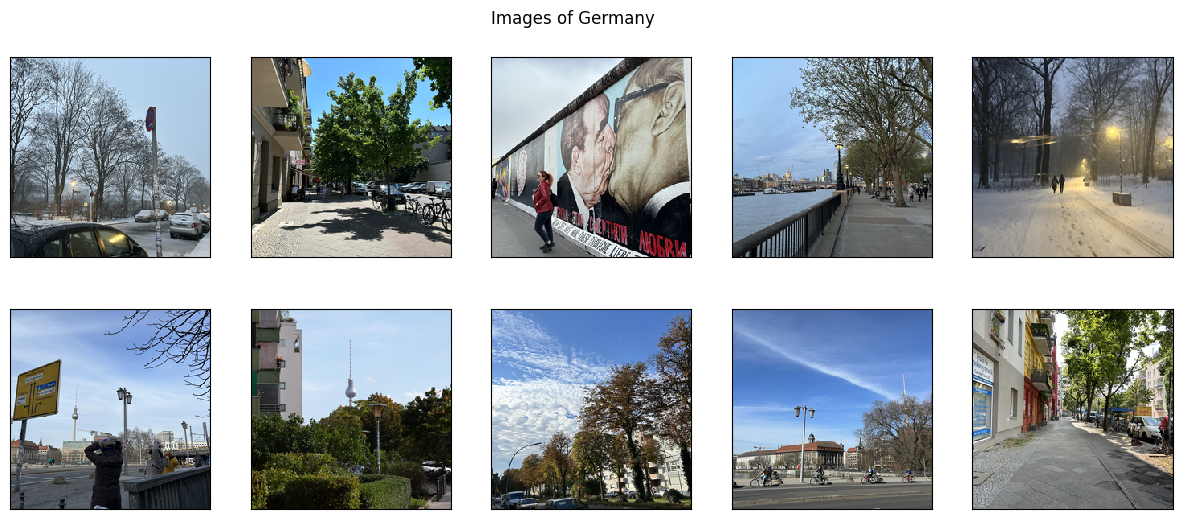

In [26]:
# This gets pictures of format jpg, jpeg, png, heic, heif, etc.
file_paths = glob('Berlin/*.*')  

# Prints data information
print(f"Found {len(file_paths)} images")
X_0 = resize_images(file_paths)

print(f'Total Images: {len(X_0)}')

# Plot samples
plot_images(X_0, germany_index)

#### Load Images from Argentina and Plot Samples

Found 110 images
Total Images: 110


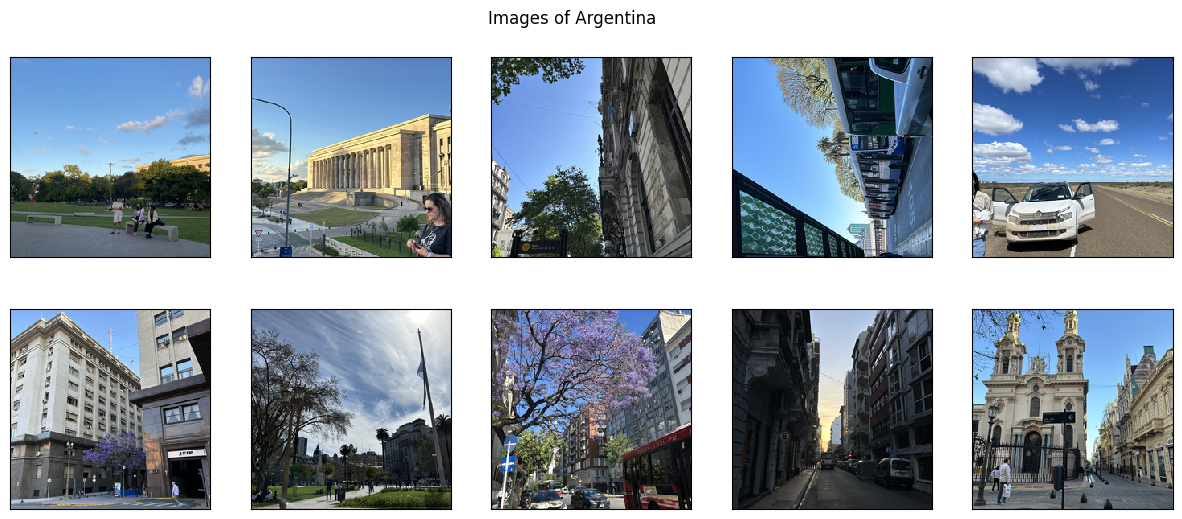

In [27]:
# This gets pictures of format jpg, jpeg, png, heic, heif, etc.
file_paths = glob('Argentina/*.*')

# Prints data information
print(f"Found {len(file_paths)} images")
X_1 = resize_images(file_paths)

print(f'Total Images: {len(X_1)}')

# Plot samples
plot_images(X_1, argentina_index)

#### Load Images from Taiwan and Plot Samples

Found 152 images
Total Images: 152


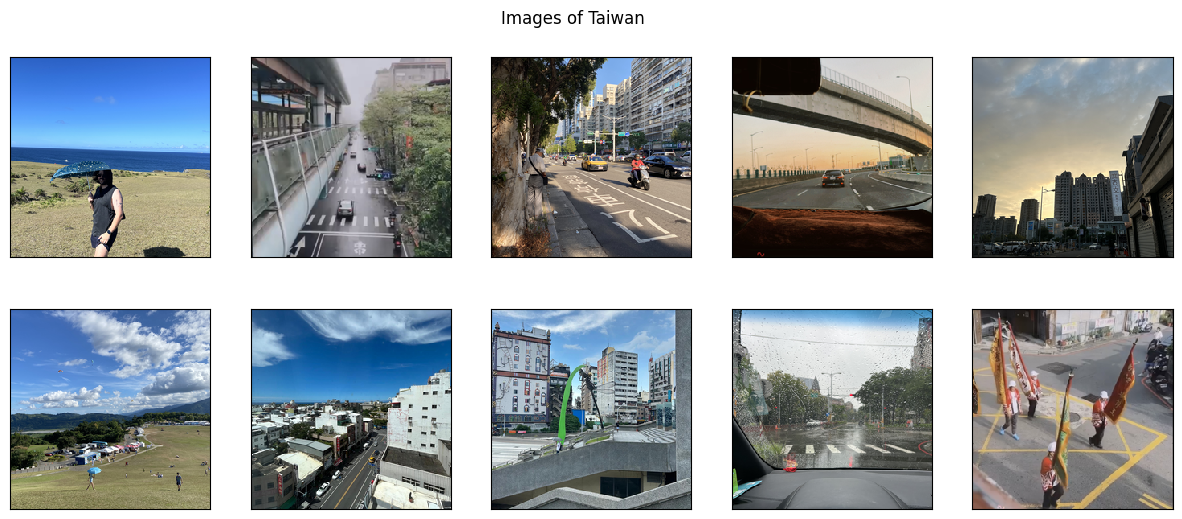

In [28]:
# Adjust glob pattern to catch both JPEG and HEIF files
file_paths = glob('Taiwan/*.*')  # This gets jpg, jpeg, png, heic, heif, etc.

print(f"Found {len(file_paths)} images")
X_2 = resize_images(file_paths)

print(f'Total Images: {len(X_2)}')

# Plot samples
plot_images(X_2, taiwan_index)

### Data Augmentation

I have around 95 pictures of Germany, 110 pictures of Argentina, and 158 pictures of Taiwan. There are not enough information to build a good model. I asked ChatGPT what are some techniques to build a more robust model with insufficient data, it suggested using pre-trained models (like MobileNetV2, EfficientNet, or ResNet) or doing data augmentation. I wanted to build a simple model merely using my own pictures, so data augmentation techniques are applied.

Data augmentation was widely used in early 2000s as the use of CNN grew larger but there were not enough data. By modifying exsiting data to create new data, we can avoid over-fitting data and enhance model generalizability. I used a mixture of data augmentation techniques that I found on Wikipedia, including geometric transformations (flipping, rotation, cropping/zooming, translation), color space transformation (brightness adjustment), and noise injection (Gaussian noise).

- Flipping: Horizontal flipping.
- Rotation: Rotating images at different angles.
- Brightness Adjustment: Increasing brightness variations.
- Translation and Zooming: Slight shifts and zoom effects prevent overfitting.
- Gaussian Noise: Adds minor noise to simulate real-world distortions.

These transformations significantly increase the dataset size to 2499 pictures, improving model performance.

Source: 
- https://en.wikipedia.org/wiki/Data_augmentation

In [60]:
def augment_images(images, image_shape=(250, 250, 3)):
    augmented_images = []

    for img_flat in images:
        # reshape flattened image to (250, 250, 3) for augmentation
        img = img_flat.reshape(image_shape)

        # apply augmentations
        flipped_img = np.fliplr(img)
        rotated_img = np.rot90(img)

        # brightness adjustment
        brighter_img = np.clip(img * 1.2, 0, 255).astype(np.uint8)

        # translation
        shifted_img = shift(img, shift=(10, 10, 0), mode='constant', cval=255)

        # zoom
        h, w = img.shape[:2]
        zoom_factor = 1.1
        zoomed_img = cv2.resize(img, None, fx=zoom_factor, fy=zoom_factor)
        center_crop = zoomed_img[
            (zoomed_img.shape[0] - h) // 2 : (zoomed_img.shape[0] + h) // 2,
            (zoomed_img.shape[1] - w) // 2 : (zoomed_img.shape[1] + w) // 2,
        ]

        # add Gaussian noise with mean of 0 and std of 10
        noise = np.random.normal(0, 10, img.shape).astype(np.uint8)
        noisy_img = np.clip(img + noise, 0, 255).astype(np.uint8) # prevent overflow

        # flatten back and append all versions
        augmented_images.extend([
            img.flatten(),
            flipped_img.flatten(),
            rotated_img.flatten(),
            brighter_img.flatten(),
            shifted_img.flatten(),
            center_crop.flatten(),
            noisy_img.flatten()
        ])

    return np.array(augmented_images)


# augment image for each class individually
X_0_aug = augment_images(X_0)
X_1_aug = augment_images(X_1)
X_2_aug = augment_images(X_2)

# combine all augmented images into one array
X = np.concatenate([X_0_aug, X_1_aug, X_2_aug], axis=0)

# create corresponding Y labels 
Y_0_aug = np.full(X_0_aug.shape[0], 0)
Y_1_aug = np.full(X_1_aug.shape[0], 1)
Y_2_aug = np.full(X_2_aug.shape[0], 2)

# combine all Y labels into one array
Y = np.concatenate([Y_0_aug, Y_1_aug, Y_2_aug], axis=0)

# shuffle combined data
X, Y = shuffle(X, Y, random_state=23)

print(f"Combined X shape: {X.shape}") 
print(f"Combined Y shape: {Y.shape}") 

Combined X shape: (2499, 187500)
Combined Y shape: (2499,)


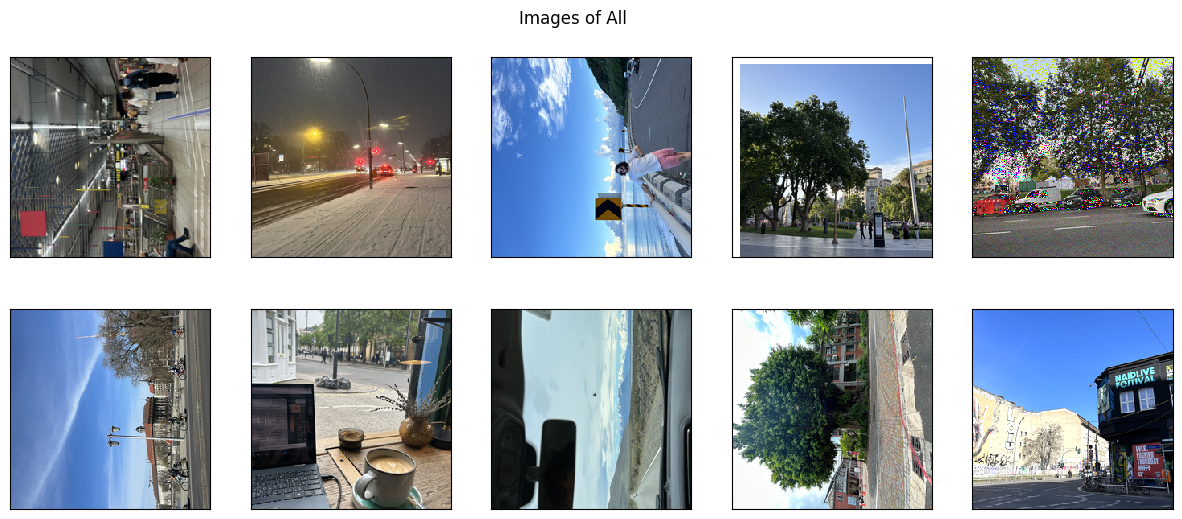

In [32]:
# plot augmented, combined, and shuffled images

plot_images(X, all_index)

### Dimensionality Reduction Using PCA

To manage computational complexity and reduce redundancy in the image dataset, Principal Component Analysis (PCA) is applied. PCA finds a set of eigenvectors of the dataset that capture the most variance in the dataset. This means that the eigenvectors we chose take the image data onto a different basis that is a linear combination of the original
basis and that can re-express the data optimally. This dataset has 2499 variables (aka 2499 dimensions). With PCA we could reduce the dimension to a number (n) that satisfies the variance threshold by simply taking the first n eigenvectors.

The number of principal components is chosen to maintain 95% of the variance, which reduces dimensions while preserves most of the image features. This step ensures that the model can train efficiently without excessive memory usage.

Source:
- Session 14 DeepDive Workbook: Flexible pipelines
- Richardson, M. (2009). Principal Component Analysis (https://people.duke.edu/~hpgavin/SystemID/References/Richardson-PCA-2009.pdf)

In [39]:
# apply PCA using all components
n_components = len(X)
pca = decomposition.PCA(n_components=n_components)

# fit images to PCA to reduce dimensions
transformed = pca.fit_transform(X)
print(transformed.shape)

# record the explained variance ratio
explained_variance = pca.explained_variance_ratio_

(2499, 2499)


Total variance = 1.00


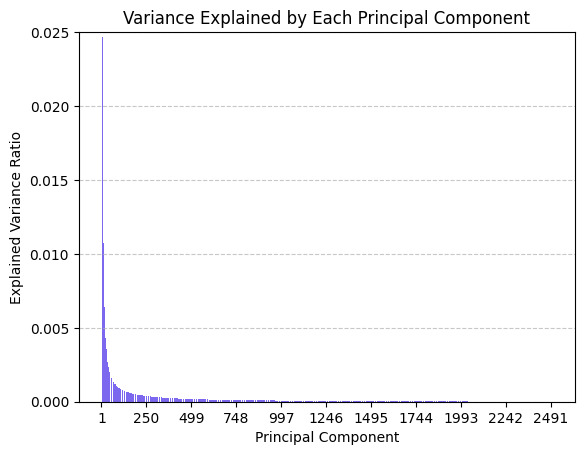

In [ ]:
# first plot - each principle component with the variance it accounts for

# check if total variance adds up to 1
print(f'Total variance = {sum(explained_variance):.2f}')

plt.figure()
plt.bar(range(1, n_components + 1), explained_variance, color='mediumslateblue')

# plot set up
plt.title('Variance Explained by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.ylim(0,0.025)
plt.xticks(range(1, n_components + 1, max(1, n_components // 10)))  # Adjusting x-ticks for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

The first bar plot shows the variance explained by each principle component. The first eigenvector captures about 2.5% of the variance, and the variance captured by the next principle components decrease exponentially. After about 997 components, there are barely any variance captured by the additional principle components. This can help us decide where to cut off the principal components for dimensional reduction.

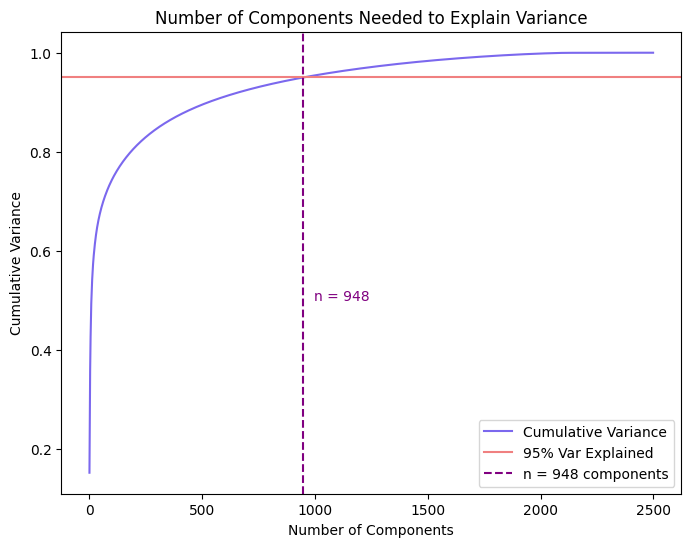

Number of components needed for 95% variance: 948


In [44]:
# second plot - plot number of components vs. explained variance threshold
plt.figure(figsize=(8,6))

components = np.arange(1, n_components+1, step=1)
var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(components, var, color='mediumslateblue', label='Cumulative Variance')

# horizontal line at 95% explained variance
plt.axhline(y=0.95, color='lightcoral', label='95% Var Explained')

# find the first component count that reaches 0.95 variance
n_95 = np.argmax(var >= 0.95) + 1  # +1 to shift from index to component count

# vertical line at this component count
plt.axvline(x=n_95, color='purple', linestyle='--', label=f'n = {n_95} components')
plt.text(n_95+50, 0.5, f'n = {n_95}', color='purple', fontsize=10)

# plot set up
plt.title('Number of Components Needed to Explain Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

plt.legend(loc=4)
plt.show()

print(f"Number of components needed for 95% variance: {n_95}")

The second plot adds up the variance captured by each principle components and set the threshold at 95%, meaning that we only keep a portion of principle components that collectivly account for 95% of the variance in the dataset and eliminate others to reduce dimensions. We found that we only need 948 principle components to get the essential variance. Instead of the original 2499 dimensions, we succesfully reduce the dimension to 948.

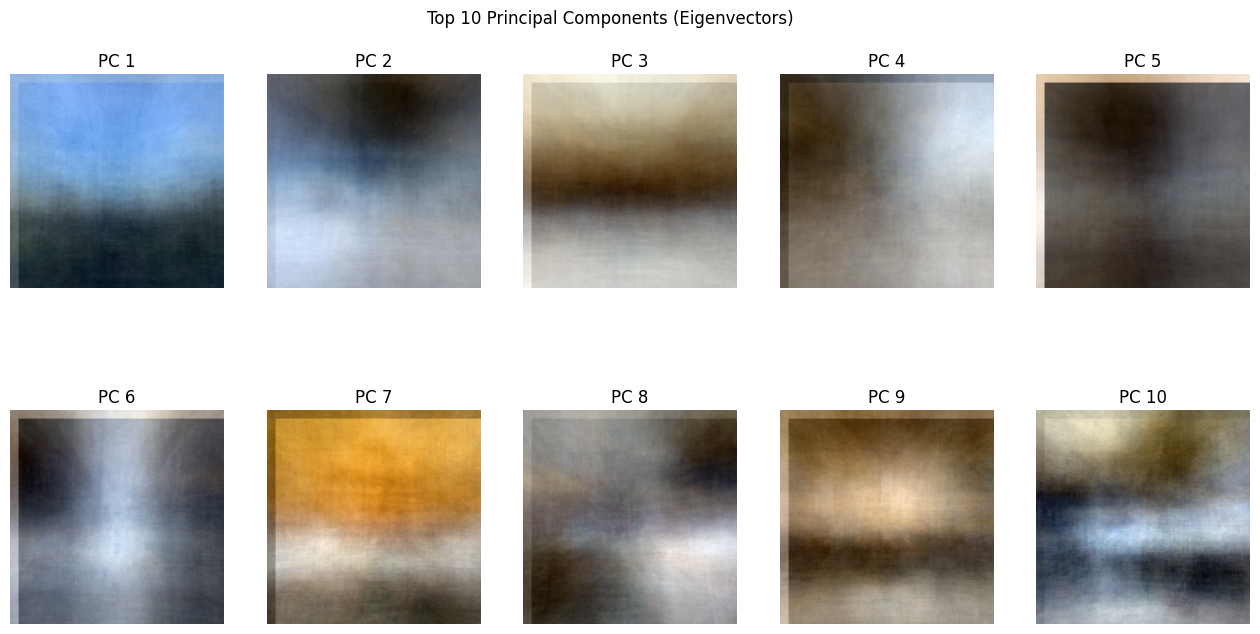

In [ ]:
# 250x250 images with 3 color channels (RGB)
img_shape = (250, 250, 3)

# plot the first 10 eigenvectors as images
fig, axes = plt.subplots(2, 5, figsize=(16, 8))

for i, ax in enumerate(axes.ravel()):
    if i >= len(pca.components_):
        break

    # Each component is a flattened image - reshape to original size
    eigenvector_image = pca.components_[i].reshape(img_shape)

    ax.imshow((eigenvector_image - eigenvector_image.min()) / (eigenvector_image.max() - eigenvector_image.min())) # normalization
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.suptitle('Top 10 Principal Components (Eigenvectors)', y=0.92)
plt.show()

The figure above displays the top 10 principal components (eigenvectors) of the image dataset. Each image represents one principal component, reshaped to the original image dimensions (250x250x3). These components capture the most significant variations in the dataset, as earlier components accounting for more variance.

In [58]:
# apply PCA transform to reduce X to 948 dimensions
pca = decomposition.PCA(n_components=948)
X_reduced = pca.fit_transform(X)

print(f"Reduced X shape: {X_reduced.shape}")

Reduced X shape: (2499, 948)


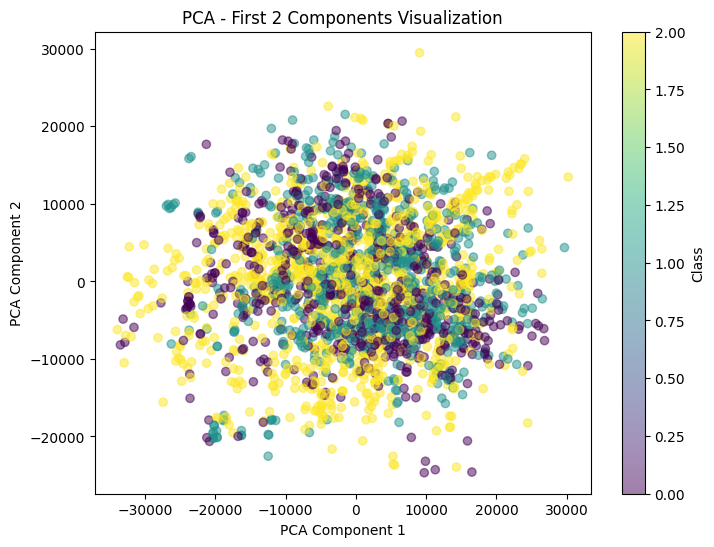

In [61]:
plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=Y, cmap='viridis', alpha=0.5)
plt.colorbar(label='Class')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA - First 2 Components Visualization')
plt.show()

The scatter plot above visualizes the image dataset reduced to two dimensions using PCA, where each point represents an image projected onto the first two principal components. The color of each point corresponds to its class label.

### Model Training and Classification

We employ a fully connected neural network built with TensorFlow/Keras to classify the images:

Set-up:
- Input layer with 948 neurons (corresponding to PCA-transformed image features).
- Two hidden layers: 128 neurons (ReLU activation) and 64 neurons (ReLU activation).
- Output layer with 3 neurons (softmax activation for multi-class classification).

Training Process:
- The dataset is split into 80% training and 20% validation using train_test_split.
- The model is optimized using the Adam optimizer and trained with categorical cross-entropy loss.
- The training runs for 50 epochs with a batch size of 32.

In [62]:
# supervised training with dataset split into 80% training and 20% validation data
X_train, X_val, Y_train, Y_val = train_test_split(X_reduced, Y, test_size=0.2, random_state=42, stratify=Y)

# set up the feedforward Neural Network Model
model = Sequential([
    InputLayer(input_shape=(948,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax') # converts outputs into class probabilities
])
model.compile(optimizer=Adam(learning_rate=0.001), # Adam -> adaptive learning rate optimization
            loss='sparse_categorical_crossentropy', # cross-entropy loss
            metrics=['accuracy'])

# trains for 50 epochs
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val))

y_val_pred = np.argmax(model.predict(X_val), axis=1)

Epoch 1/50


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4513 - loss: 395.1916 - val_accuracy: 0.6680 - val_loss: 104.9319
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9122 - loss: 16.9054 - val_accuracy: 0.6980 - val_loss: 91.8186
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9565 - loss: 4.5626 - val_accuracy: 0.7160 - val_loss: 92.8766
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9826 - loss: 1.2240 - val_accuracy: 0.7280 - val_loss: 95.1788
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.9922 - loss: 0.2955 - val_accuracy: 0.7300 - val_loss: 97.0331
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9901 - loss: 0.8530 - val_accuracy: 0.7320 - val_loss: 94.4533
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9871 - loss: 0.7596 - val_accuracy: 0.7300 - val_loss: 92.6008
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.9916 - loss: 0.3887 - val_accuracy: 0.7440 - val_l

We can break the model training down into three main steps: build a feedforward structure with predetermined layers, performs backpropagation for gradient calculation, and update weights with gradient descent.

### **1. Feedforward Pass**
In a fully connected neural network, each neuron applies a linear transformation followed by a non-linear activation function. The linear transformation takes input from the previous layer, multiplies it with the weights and adds its bias to be the output. As the model is fully connected, it will take the input from every neuron from the previous layer.   

For a single layer, the linear transformation can be represented by the equation:

$$
Z^{(l)} = W^{(l)} A^{(l-1)} + b^{(l)}
$$

where $ Z^{(l)} $ is the output of layer $ l $, $ W^{(l)} $ is the weight matrix of layer $ l $, $ A^{(l-1)} $ is the activations from the previous layer, and $ b^{(l)} $ is the bias term.  

### Activation Function
Then, the linear outcome is activated by the non-linear activation, which allows the model to learn complex, non-linear relationships. This model implements ReLU (Rectified Linear Unit), which is a piecewise linear function that keeps the positive values from $Z$ while set negative values to 0. The formula is:

$$
A^{(l)} = f(Z^{(l)}) = \max(0, Z^{(l)})
$$

For the output layer, softmax is used:

$$
\hat{y}_i = \frac{e^{Z_i}}{\sum_{j} e^{Z_j}}
$$

where $ \hat{y}_i $ is the predicted probability of class $ i $. The prediction will be based on the class that has the highest $ \hat{y} $ value. The denominator ensures probabilities sum to 1.

### **2. Backpropagation (Computing Gradients)**
Backpropagation applies the chain rule of calculus to compute how much each weight contributes to the error.

### Loss Function (Cross-Entropy)
The model is trained using categorical cross-entropy loss. It measures how well the predicted probability $\hat{y}_i$ matches with the true class label ${y}_i$. The calculation follows the equation:

$$
L = - \sum_{i=1}^{n} y_i \log(\hat{y}_i)
$$

where $ y_i $ is the true label (one-hot encoded, meaning that the true label is 1 and other two are 0), and $ \hat{y}_i $ is the predicted probability. If the model assigns high probability to the correct class, the loss will be small. And if the model assigns low probability to the correct class, the loss will be large.

The goal of backpropagation is to compute the following:

$$
\frac{\partial L}{\partial W^{(l)}}, \quad \frac{\partial L}{\partial b^{(l)}}
$$

which tells us how much the loss function $L$ (which represents the correctness of the model) changes when weights $W$ and bias $b$ change, to help with updating the weights and biases.

### Gradient Computation via Chain Rule
For each weight, we use the chain rule:

$$
\frac{\partial L}{\partial W^{(l)}} = \frac{\partial L}{\partial A^{(l)}} \cdot \frac{\partial A^{(l)}}{\partial Z^{(l)}} \cdot \frac{\partial Z^{(l)}}{\partial W^{(l)}}
$$

### **3. Weight Update (Gradient Descent)**
After computing gradients, we update the weights using gradient descent. The gradient descent update rules are as follow:
$$
W^{(l)} = W^{(l)} - \eta \frac{\partial L}{\partial W^{(l)}}
$$

$$
b^{(l)} = b^{(l)} - \eta \frac{\partial L}{\partial b^{(l)}}
$$

where $ \eta $ is the learning rate that controls how big the step is.

### Adam Optimizer (Adaptive Moment Estimation)
Adam improves gradient descent by using momentum and adaptive learning rates (RMSprop), which are two powerful techniques when adjusting weights and biases for the model

1. Momentum: It can accelerate the gradient descent process as it incoperates an exponentially weighted moving average of past gradients. The update formula is as follows:

   $$
   w_{t+1} = w_t - \alpha m_t
   $$
   
   where $m_t$ is the moving average of the gradients at time $t$, $\alpha$ is the learning rate, and $w_t$ and $w_{t+1}$ are weights at time $t$ and $t+1$.

2. RMSprop: RMSprop is an adaptive learning rate method with an exponentially weighted moving average of squared gradients to avoid problem of diminishing learning rates. The weight update formla is as follows:

   $$
   W^{(l)} = W^{(l)} - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
   $$
   where $\hat{m}_t$ is the mean estimate and $\hat{v}_t$ is the variance estimate, and $ \epsilon $ is a small positive constant that prevents division by zero.

Source:
- https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
- https://www.datacamp.com/tutorial/the-cross-entropy-loss-function-in-machine-learning
- https://www.geeksforgeeks.org/adam-optimizer/

              precision    recall  f1-score   support

     Germany       0.69      0.71      0.70       133
   Argentina       0.81      0.73      0.77       154
      Taiwan       0.81      0.85      0.83       213

    accuracy                           0.77       500
   macro avg       0.77      0.76      0.76       500
weighted avg       0.77      0.77      0.77       500



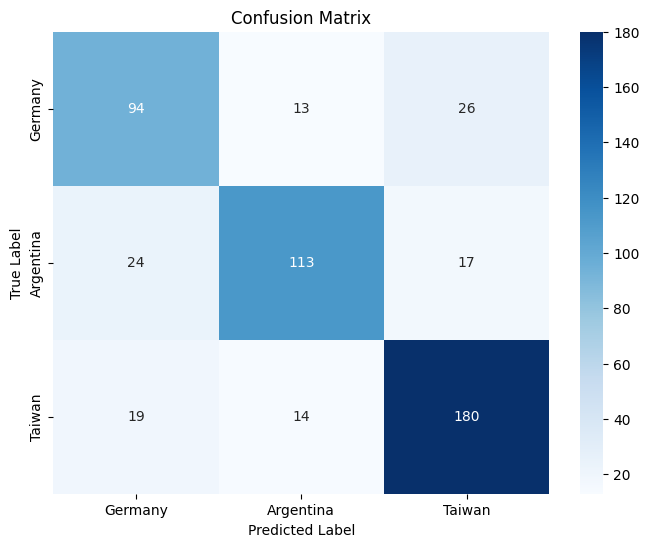

In [63]:
# generate classification report
report = classification_report(Y_val, y_val_pred, target_names=['Germany', 'Argentina', 'Taiwan'])
print(report)

# plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

cm = confusion_matrix(Y_val, y_val_pred)
plot_confusion_matrix(cm, class_names=['Germany', 'Argentina', 'Taiwan'])

To evaluate our model, we used the `classification_report()` in Scikit-learn that calculates the precision, recall, f-score, and accuracy of this model.

Firstly, precision measures how many of the predicted positive are actually correct. This is useful to look at when false positives are costly (such as spam detection).

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

Secondly, recall measures how many actual positive were correctly predicted. This is useful when false negatives are more costly, such as cancer detection.

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

Thirdly, the F1-Score is the combination of precision and recall to balance between emphasizing false postive and false negative, which is calculated by the formula:
$$
\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Lastly, accuracy measures the proportion of correct predictions out of all predictions. This is not useful when the dataset is imbalanced as it can be misleading. It is fine to look at for this model as the three classes have similar amount of data.

$$
\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}}
$$

The model has 79% accuracy, which gives space for improvement but it is not too bad.

For individual country:

- Germany: Precision = 69%, Recall = 71%
- Argentina: Precision = 81%, Recall = 73%
- Taiwan: Precision = 81%, Recall = 85%

Taiwan has the best recall and reasonably good precision, this can result from having the most data (158 images before augmentation) out of the three classes.

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step


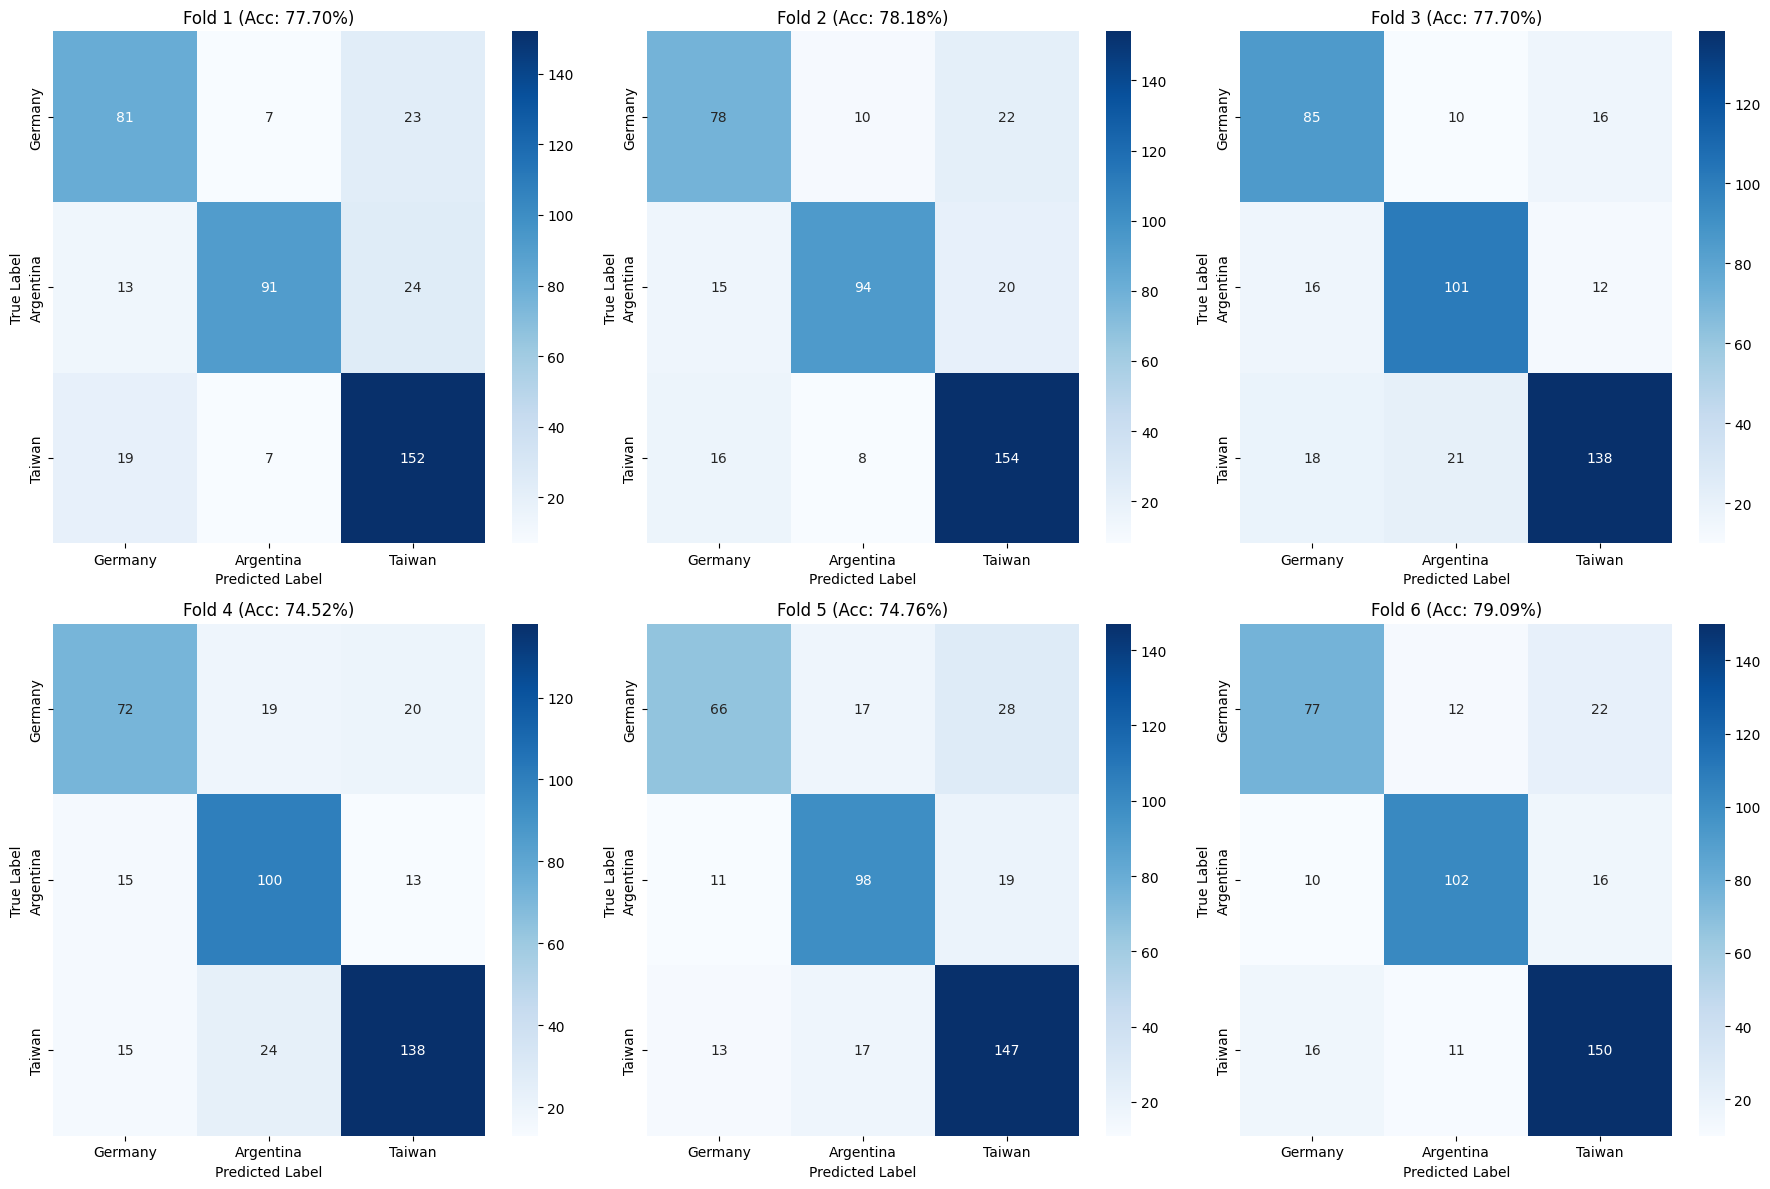

In [67]:
# set up k-fold cross validation (6 folds here)
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

# set up figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

accuracies = []

for fold_num, (train_index, val_index) in enumerate(skf.split(X_reduced, Y)):
    
    # split to training and validation
    X_train, X_val = X_reduced[train_index], X_reduced[val_index]
    y_train, y_val = Y[train_index], Y[val_index]

    # train the model
    model = Sequential([
        InputLayer(input_shape=(X_reduced.shape[1],)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # fit the model using training data
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    y_val_pred = np.argmax(model.predict(X_val), axis=1)
    
    # compute accuracy
    accuracy = np.mean(y_val_pred == y_val) * 100 
    accuracies.append(accuracy)

    # generate confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)

    # plot the confusion matrix in the corresponding subplot
    ax = axes[fold_num // 3, fold_num % 3] 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Germany', 'Argentina', 'Taiwan'],
                yticklabels=['Germany', 'Argentina', 'Taiwan'], ax=ax)
    ax.set_title(f'Fold {fold_num + 1} (Acc: {accuracy:.2f}%)')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [69]:
mean_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {mean_accuracy:.2f}%")

Average Accuracy: 76.99%


Lastly, we applied cross-validation to test the model stability across different training and validation splits. The classification resulted in the accuracy of 76.99%, which provides more accurate demonstration of the model's performance than only spliting traning and testing splits once. However, this accuracy also signs the posibility to improve. 

In the future assignments, to improve model performance, we can try to use Convolutional Neural Networks (CNNs) for feature extraction instead of PCA, add more images to expand and diversify the dataset, and implement a pre-trained model or APA for gaining more practical experience with the common tools used in real-world model trainings.